In [3]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 91 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=54b579c92752f5b2453b76c5d1829c3efec02c5a47e429a5718e780e5d4b3408
  Stored in directory: /tmp/pip-ephem-wheel-cache-p7raf333/wheels/55/59/29/0fb1c6356521

In [4]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [5]:
import torch.nn as nn
import torch
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [12]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


In [13]:
class Model(nn.Module):
    def __init__(self, hd=256, latent_size=128, tau=0.99):
        super().__init__()
        self.teacher = Net()
        self.student = copy.deepcopy(self.teacher)
        self.predictor = nn.Sequential(
            nn.Linear(latent_size, hd), nn.BatchNorm1d(hd), nn.ReLU(),
            nn.Linear(hd, hd), nn.BatchNorm1d(hd), nn.ReLU(),
            nn.Linear(hd, latent_size)
        )
        self.tau = tau

        for param in self.teacher.parameters():
            param.requires_grad = False


    def update(self):
        for param_t, param_s in zip(self.teacher.parameters(), self.student.parameters()):
            param_t.data = self.tau * param_t.data + (1 - self.tau) * param_s.data

    def similarity(self, x, y):
        q_z_t = self.predictor(self.teacher(x))
        with torch.no_grad():
            z_s = self.student(y).detach()

        cosine = torch.sum(q_z_t * z_s, dim=1) / (torch.norm(q_z_t, dim=1) * torch.norm(z_s, dim=1))
        out = 2 - 2 * cosine
        return out.mean()

    def loss(self, x, y):
        return self.similarity(x, y) + self.similarity(y, x)

    def representations(self, x):
        x = x.to(device)
        self.student.eval()
        with torch.no_grad():
            out = self.student(x).detach()
        return out


In [14]:
device = 'cuda'

def train(model, train_data, epochs=10, lr=1e-3, bs=128):
    opt = Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
    losses = []

    for epoch in tqdm(range(epochs)):
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)

            loss = model.loss(x, y)
            opt.zero_grad()
            loss.backward()
            opt.step()

            model.update()
            losses.append(loss.item())

    return np.array(losses)

In [15]:
from torchvision.transforms.transforms import ToPILImage
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=28),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx][0].add(1).sub(2)
        x1 = self.transforms(x)
        x2 = self.transforms(x)
        return x1, x2

In [16]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    dataset = CustomDataset(train_data)
    model = Model().to(device)

    losses = train(model, dataset, epochs=10)

    return losses, model.representations

100%|██████████| 10/10 [14:19<00:00, 85.93s/it]


mean classification accuracy=0.5443


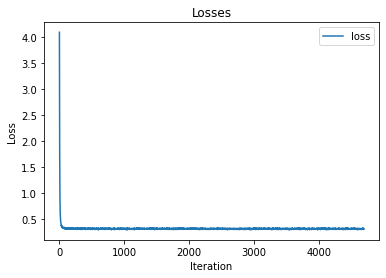

In [17]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)